# Проверка Гипотез

*Проверка гипотез был проведена по алгоритму, представленный в презентации пятого урока*
 1. Определить фактор и отклик
 2. Определить шкалы фактора и отклика
 3. Собрать данные
 4. Выбрать тип графика и провести графический анализ
 5. Выбрать метод проверки гипотезы
 6. Рассчитать статистическую значимость
 7. Сделать окончательный вывод

*При выборе метода мы ориентировались на график, представленный в презентации пятого урока.*

![Image](choosing_correct_statistical_test.jpg)

*В ходе проверки гипотез был выбран следующий набор параметров:*
- Уровень статистической значимости (p-уровень) установлен на 0.05.

Исследуемые параметры и краткий вывод:
>1. **Возраст (количественная)**: не влияет
>2. **АИК (интраоперационные)**: позитивная корреляция на уровне 2.3
>3. **Длительность работы АИК (интраоперационные)**: позитивная корреляция
>4. **Частота сокращений сердца (анамнез)**: не влияет
>5. **Мочевина в крови (биохимия)**: не влияет
>6. **ХБП**: хроническая болезнь почек (анамнез)**: не влияет
>7. **Холестерин (биохимия)**: не влияет
>8. **Сахарный диабет (анамнез)**: не влияет
>9. **Время пережатия аорты (интраоперационные)**: сам факт имеет позитивную корреляцую на уровне 2.3, а время нет
>10. **Калий (биохим)**: не влияет

В общем 3 анамнез, 3 биохимия, 3 интраоперационные факторы

In [117]:
import pandas as pd
import seaborn as sns
from scipy import stats

In [118]:
def check_normality(data):
    _, p_value_normality = stats.shapiro(data)
    if p_value_normality < 0.05:
        print("Данные распределены ненормально")
    else:
        print("Данные распределены нормально")


def check_hypothesis(group1, group2, method) -> None:
    if method == "Хи-квадрат":
        contigency_table = pd.crosstab(group1, group2)
        chi2 = stats.chi2_contingency(contigency_table)
        cor, pvalue = chi2.statistic, chi2.pvalue
    elif method == "Т-критерий Стьюдента":
        cor, pvalue = stats.ttest_ind(group1, group2, equal_var=False)
    elif method == "U-критерий Манна-Уитни":
        cor, pvalue = stats.mannwhitneyu(group1, group2)
    cor = round(cor, 2)
    pvalue = round(pvalue, 2)
    print(f"корреляция={cor}, p-уровень={pvalue}")
    if pvalue < 0.05:
        print("Отвергнуть нулевую гипотезу")
    else:
        print("Мы не можем отвергнуть нулевую гипотезу")

Мы выдвигаем гипотезы по влиянию разных факторов на риск развития ОПП, поэтому шкала отклика для всех гипотез один - номинальная (2 уровень), поэтому делим данные на две части на основе наличие ОПП для удобства

In [119]:
data = pd.read_csv("content/processed_data.csv", encoding="utf-8")

# aki - Acute kidney injury (острое поражение почек)
aki_absent = data[data["развитие_опп"] == "нет"]
aki_present = data[data["развитие_опп"] == "есть"]

## 1. Возраст (количественная)

$H_{0}$: Нету корреляции между фактором возрастом и откликом риском развития ОПП\
$H_{1}$: Есть корреляция между фактором возрастом и откликом риском развития ОПП

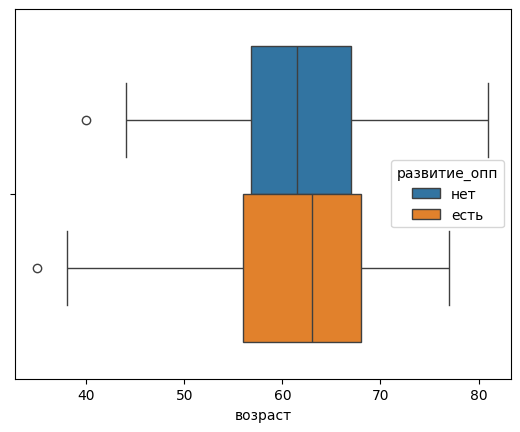

In [120]:
ax = sns.boxplot(x="возраст", hue="развитие_опп", data=data)

In [121]:
aki_absent_age = aki_absent["возраст"]
aki_present_age = aki_present["возраст"]

check_normality(aki_absent_age)
check_normality(aki_present_age)

Данные распределены нормально
Данные распределены ненормально


В одном из групп ненормальное распределение и шкала фактор - количественная, поэтому используем метод U-критерия Манна-Уитни

In [122]:
check_hypothesis(aki_absent_age, aki_present_age, method="U-критерий Манна-Уитни")

корреляция=3895.0, p-уровень=0.74
Мы не можем отвергнуть нулевую гипотезу


При таком уровне значимости можно сделать вывод, что нету корреляции между фактором возрастом и риском развития ОПП

## 2. АИК (интраоперационные) 

$H_{0}$: Нету корреляции между фактором АИК и откликом риском развития ОПП\
$H_{1}$: Есть корреляция между фактором АИК и откликом риском развития ОПП 

<Axes: xlabel='развитие_опп'>

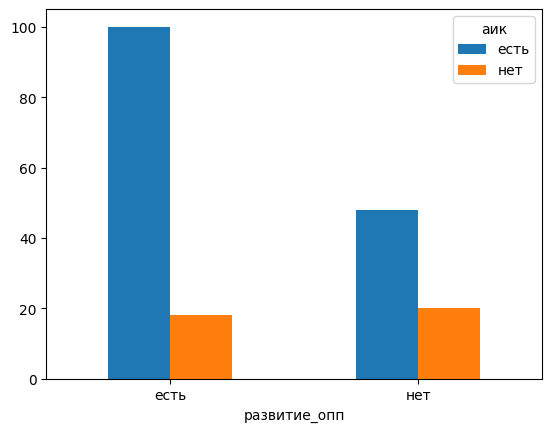

In [123]:
data = data.replace({"аик": {0: "нет", 1: "есть"}})
crosstab = pd.crosstab(index=data["развитие_опп"], columns=data["аик"])

crosstab.plot.bar(rot=0)

Фактор АИК - бинарный (номинальный), поэтому будет использован критерий "Хи-квадрат"

In [124]:
check_hypothesis(data["аик"], data["развитие_опп"], method="Хи-квадрат")

корреляция=4.48, p-уровень=0.03
Отвергнуть нулевую гипотезу


При таком уровне значимости можно сделать вывод, что присутсвует связь между фактором АИК и откликом риском развития ОПП. Исследуем эту связь дальше. 

Рассмотрим насколько увеличиваеться вероятность развития ОПП при наличии АИК

In [125]:
res = stats.contingency.odds_ratio(crosstab)
round(res.statistic, 2)

2.3

Из этого следует вывод, что вероятность получить ОПП у пациентов с АИК в 2,3 раза выше, чем у пациентов без АИК

## 3. Длительность работы АИК (интраоперационные) 

$H_{0}$: Нету корреляции между фактором длительности работы АИК и откликом риском развития ОПП\
$H_{1}$: Есть корреляция между фактором длительности работы АИК и откликом риском развития ОПП 

Очевидно, что длительность работы АИК имеет место быть только при наличие АИК, поэтому будет исследовать только данные с наличием АИК

In [126]:
# hlm - heart lung machine (аппарат исскуственного кровообращения)
hlm_present = data[data['аик'] == 'есть']

<Axes: xlabel='длительность_аик'>

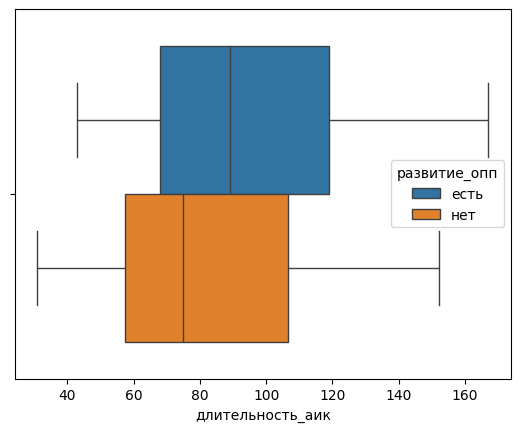

In [127]:
sns.boxplot(x=hlm_present['длительность_аик'], hue=hlm_present['развитие_опп'])

In [128]:
aki_absent_hlm_duration = hlm_present[hlm_present["развитие_опп"] == "нет"]["длительность_аик"]
aki_present_hlm_duration = hlm_present[hlm_present["развитие_опп"] == "есть"]["длительность_аик"]

check_normality(aki_absent_hlm_duration)
check_normality(aki_present_hlm_duration)

Данные распределены ненормально
Данные распределены ненормально


У обоих групп ненормальное распределние и фактор "длительность_аик" количественный, поэтому используем метод U-критерия Манна-Уитни

In [129]:
check_hypothesis(aki_absent_hlm_duration, aki_present_hlm_duration, method='U-критерий Манна-Уитни')

корреляция=1866.0, p-уровень=0.03
Отвергнуть нулевую гипотезу


При таком уровне значимости можно сделать вывод, что присутствует связь между фактором длительности АИК и откликом риском развития ОПП. Исследуем эту связь дальше

In [130]:
round(aki_present_hlm_duration.mean() / aki_absent_hlm_duration.mean(), 2)

1.15

Пациенты с ОПП имели на 15% больше длительности АИК чем пациненты без ОПП. Из этого следует вывод, что чем больше времени пациент проводит с АИК, то тем выше шансы получить ОПП

## 4. Частота сокращений сердца (анамнез)

$H_{0}$: Нету корреляции между фактором ЧСС и откликом риском развития ОПП\
$H_{1}$: Есть корреляция между фактором ЧСС и откликом риском развития ОПП  

<Axes: xlabel='чсс'>

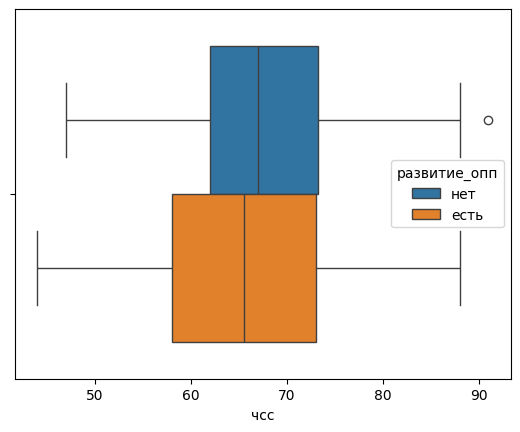

In [131]:
sns.boxplot(x="чсс", hue="развитие_опп", data=data)

In [132]:
aki_absent_heart_rate = aki_absent['чсс']
aki_present_heart_rate = aki_absent['чсс']

check_normality(aki_absent_heart_rate)
check_normality(aki_present_heart_rate)

Данные распределены нормально
Данные распределены нормально


У обоих групп нормальное распределение, поэтому используем метод Т-критерия Стьюдента

In [133]:
check_hypothesis(
    aki_absent_heart_rate, aki_present_heart_rate, method="Т-критерий Стьюдента"
)

корреляция=0.0, p-уровень=1.0
Мы не можем отвергнуть нулевую гипотезу


При таком уровне значимости можно сделать вывод, что точно нет корреляции между ЧСС и риском развития ОПП

## 5. Мочевина в крови (биохимия)

$H_{0}$: Нету корреляции между фактором мочевины в крови и откликом риском развития ОПП\
$H_{1}$: Есть корреляция между фактором мочевины в крови и откликом риском развития ОПП  

<Axes: xlabel='мочевина'>

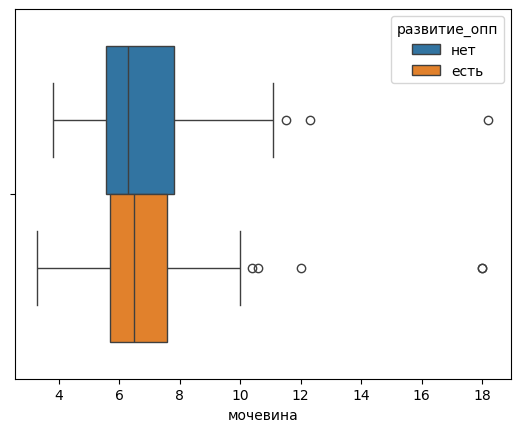

In [134]:
sns.boxplot(x='мочевина', hue='развитие_опп', data=data)

In [135]:
aki_absent_urea = aki_absent['мочевина']
aki_present_urea = aki_present['мочевина']

check_normality(aki_absent_urea)
check_normality(aki_present_urea)

Данные распределены ненормально
Данные распределены ненормально


Данные распределены ненормально, шкала фактора - количественная, поэтому используем U-критерий Манна-Уитни

In [136]:
check_hypothesis(aki_absent_urea, aki_present_urea, method="U-критерий Манна-Уитни")

корреляция=4004.5, p-уровень=0.98
Мы не можем отвергнуть нулевую гипотезу


При таком уровне значимости мы можем уверенно сказать, что нету связи между фактором ЧСС и откликом риском развития ОПП

## 6. ХБП - хроническая болезнь почек (анамнез)

$H_{0}$: Нету корреляции между фактором ХБП и откликом риском развития ОПП\
$H_{1}$: Есть корреляция между фактором ХБП и откликом риском развития ОПП  

<Axes: xlabel='развитие_опп'>

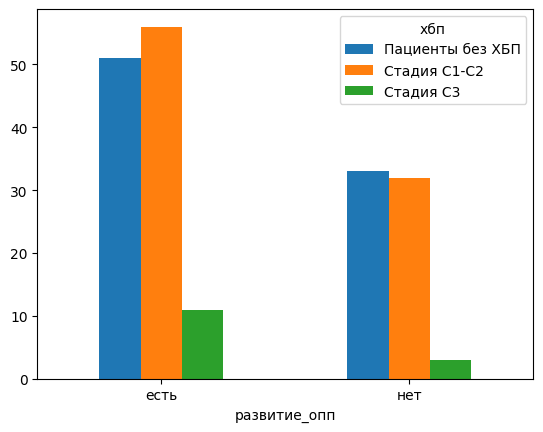

In [137]:
crosstab = pd.crosstab(index=data["развитие_опп"], columns=data["хбп"])

crosstab.plot.bar(rot=0)

In [138]:
check_hypothesis(data["хбп"], data["развитие_опп"], method="Хи-квадрат")

корреляция=1.65, p-уровень=0.44
Мы не можем отвергнуть нулевую гипотезу


При таком уровне значимости мы может заявить, что нету связи между фактором ХБП и откликом риском развития ОПП

## 7. Холестерин (биохимия)

$H_{0}$: Нету корреляции между фактором холестерин и откликом риском развития ОПП\
$H_{1}$: Есть корреляция между фактором холестерин и откликом риском развития ОПП  

<Axes: xlabel='холестерин'>

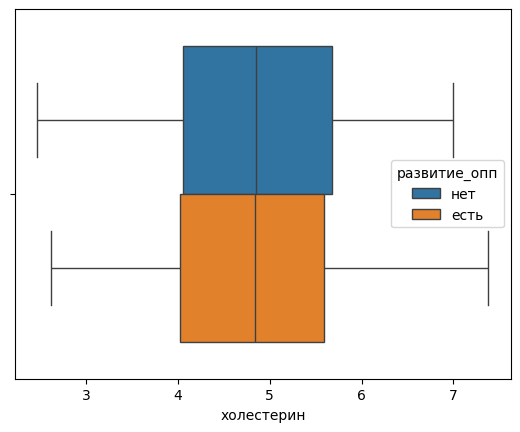

In [139]:
sns.boxplot(x='холестерин', hue='развитие_опп', data=data)

In [140]:
aki_absent_cholesterol = aki_absent['холестерин']
aki_present_cholesterol = aki_present['холестерин']

check_normality(aki_absent_cholesterol)
check_normality(aki_present_cholesterol)

Данные распределены нормально
Данные распределены нормально


Данные распределены нормально, шкала фактора - количественная, поэтому используем Т-критерий Стьюдента

In [141]:
check_hypothesis(aki_absent_cholesterol, aki_present_cholesterol, method='Т-критерий Стьюдента')

корреляция=-0.56, p-уровень=0.58
Мы не можем отвергнуть нулевую гипотезу


In [142]:
round(aki_present_cholesterol.mean() / aki_absent_cholesterol.mean(), 2)

1.02

При таком уровне значимости  и незначительной разницы в средних мы может заявить, что нету связи между фактором холестерин и откликом риском развития ОПП

## 8. Сахарный диабет (анамнез)

$H_{0}$: Нету корреляции между фактором сахарный_диабет и откликом риском развития ОПП\
$H_{1}$: Есть корреляция между фактором сахарный_диабет и откликом риском развития ОПП  

<Axes: xlabel='развитие_опп'>

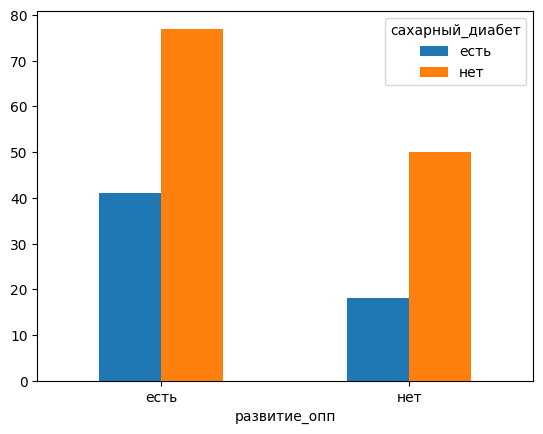

In [143]:
data = data.replace({"сахарный_диабет": {0: "нет", 1: "есть"}})
crosstab = pd.crosstab(index=data["развитие_опп"], columns=data["сахарный_диабет"])
crosstab.plot.bar(rot=0)

Фактор сахарный_диабет - бинарный (номинальный), поэтому будет использован критерий "Хи-квадрат"

In [144]:
check_hypothesis(data["сахарный_диабет"], data["развитие_опп"], method="Хи-квадрат")

корреляция=1.01, p-уровень=0.32
Мы не можем отвергнуть нулевую гипотезу


При таком уровне значимости можно сделать вывод, что отсутсвует связь между фактором сахарный диабет и откликом риском развития ОПП. 

## 9. Время пережатия аорты (интраоперационные)

Так как факт пережатия аорты очень сильно влияет на почки, поэтому сперва нужно исследовать это, а потом устанавливать связь длительности пережатия и риском развития ОПП

### Фактор пережатия аорты 

$H_{0}$: Нету корреляции между фактором фактом пережатии аорты и откликом риском развития ОПП\
$H_{1}$: Есть корреляция между фактором фактом пережатии аорты и откликом риском развития ОПП  

<Axes: xlabel='развитие_опп'>

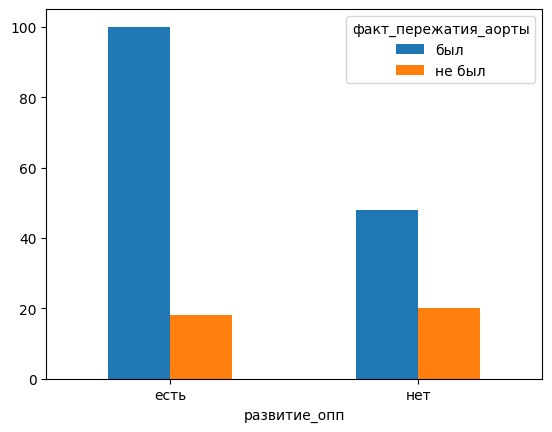

In [145]:
data["факт_пережатия_аорты"] = data["время_пережатия_аорты"].apply(
    lambda x: "был" if x > 0 else "не был"
)
crosstab = pd.crosstab(index=data["развитие_опп"], columns=data["факт_пережатия_аорты"])
crosstab.plot.bar(rot=0)

In [146]:
check_hypothesis(data["факт_пережатия_аорты"], data["развитие_опп"], method="Хи-квадрат")

корреляция=4.48, p-уровень=0.03
Отвергнуть нулевую гипотезу


При таком уровне значимости можно сказать, что факт пережатия аорты имеет влияние на риск развития ОПП. Исследуем эту связь

In [147]:
crosstab = pd.crosstab(index=data["развитие_опп"], columns=data["факт_пережатия_аорты"])
res = stats.contingency.odds_ratio(crosstab)
round(res.statistic, 2)

2.3

Из этого следует вывод, что вероятность получить ОПП у пациентов, у которых было пережатие аорты, выше на 2.3 раза, чем у пациентов не переживших это

### Время пережатия аорты

$H_{0}$: Нету корреляции между фактором временм пережатии аорты и откликом риском развития ОПП\
$H_{1}$: Есть корреляция между фактором времени пережатии аорты и откликом риском развития ОПП  

<Axes: xlabel='время_пережатия_аорты'>

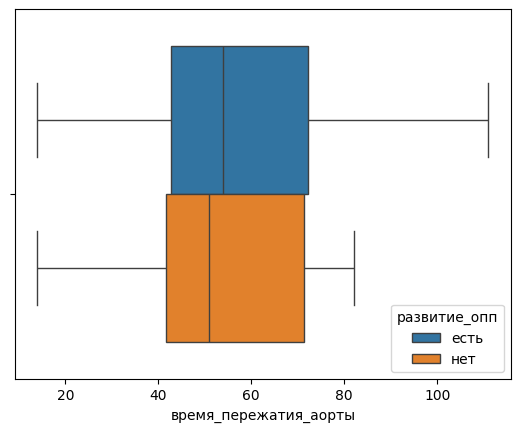

In [148]:
aorta_duration = data[data['время_пережатия_аорты'] > 0]
sns.boxplot(x='время_пережатия_аорты', hue='развитие_опп', data=aorta_duration)

In [149]:
aki_absent_aorta_duration = aorta_duration[aorta_duration["развитие_опп"] == "нет"]['время_пережатия_аорты']
aki_present_aorta_duration = aorta_duration[aorta_duration["развитие_опп"] == "есть"]['время_пережатия_аорты']

check_normality(aki_absent_aorta_duration)
check_normality(aki_present_aorta_duration)

Данные распределены нормально
Данные распределены нормально


Данные распределены нормально, шкала фактора - количественная, поэтому используем Т-критерий Стьюдента

In [150]:
check_hypothesis(aki_absent_aorta_duration, aki_present_aorta_duration, method='Т-критерий Стьюдента')

корреляция=-1.58, p-уровень=0.12
Мы не можем отвергнуть нулевую гипотезу


Из этого следует, что, хотя факт пережатия аорты сильно влияет на риск развития ОПП, но на сама длительность процесса не влияет на это

## 10. Калий (биохим)

$H_{0}$: Нету корреляции между фактором калий и откликом риском развития ОПП\
$H_{1}$: Есть корреляция между фактором калий и откликом риском развития ОПП  

<Axes: xlabel='калий'>

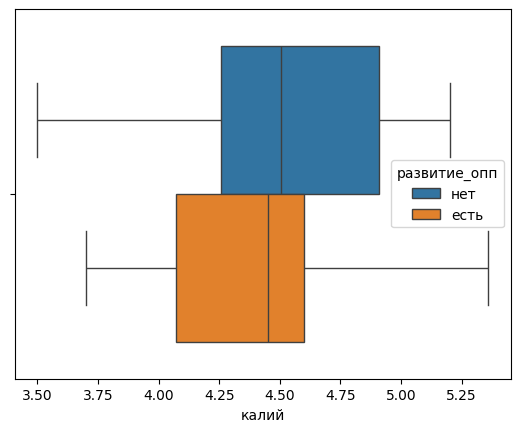

In [151]:
sns.boxplot(x='калий', hue='развитие_опп', data=data)

In [152]:
aki_absent_potassium = aki_absent['калий']
aki_present_potassium = aki_present['калий']

check_normality(aki_absent_potassium)
check_normality(aki_present_potassium)

Данные распределены ненормально
Данные распределены ненормально


Обе группы распределены ненормально, шкала фактора - количественная, поэтому используем U-критерий Манна-Уитни

In [153]:
check_hypothesis(aki_absent_potassium, aki_present_potassium, method='U-критерий Манна-Уитни')

корреляция=4854.0, p-уровень=0.02
Отвергнуть нулевую гипотезу


При таком уровне значимости можно сделать вывод, что уровень калия влияет на риск развития ОПП